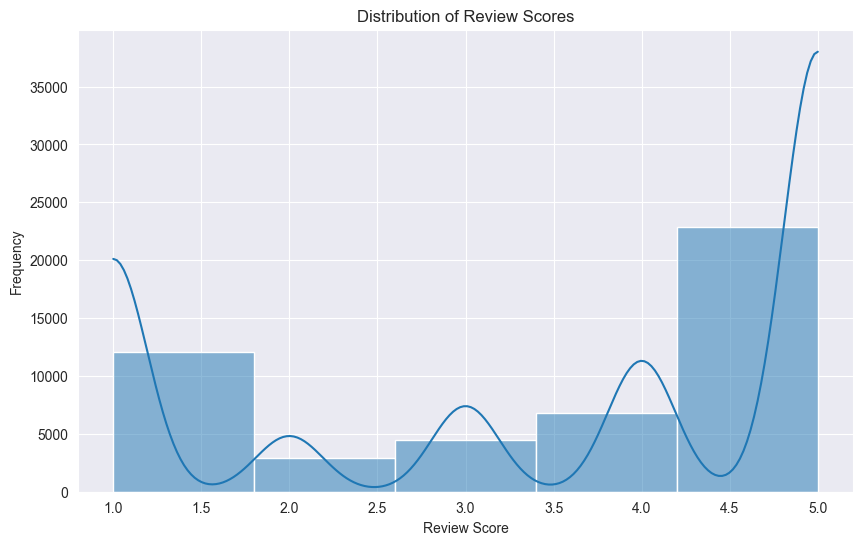

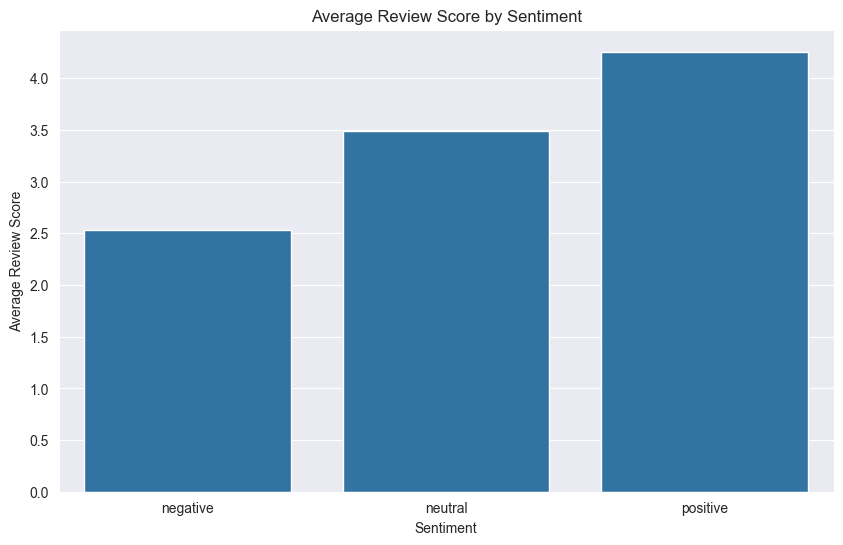

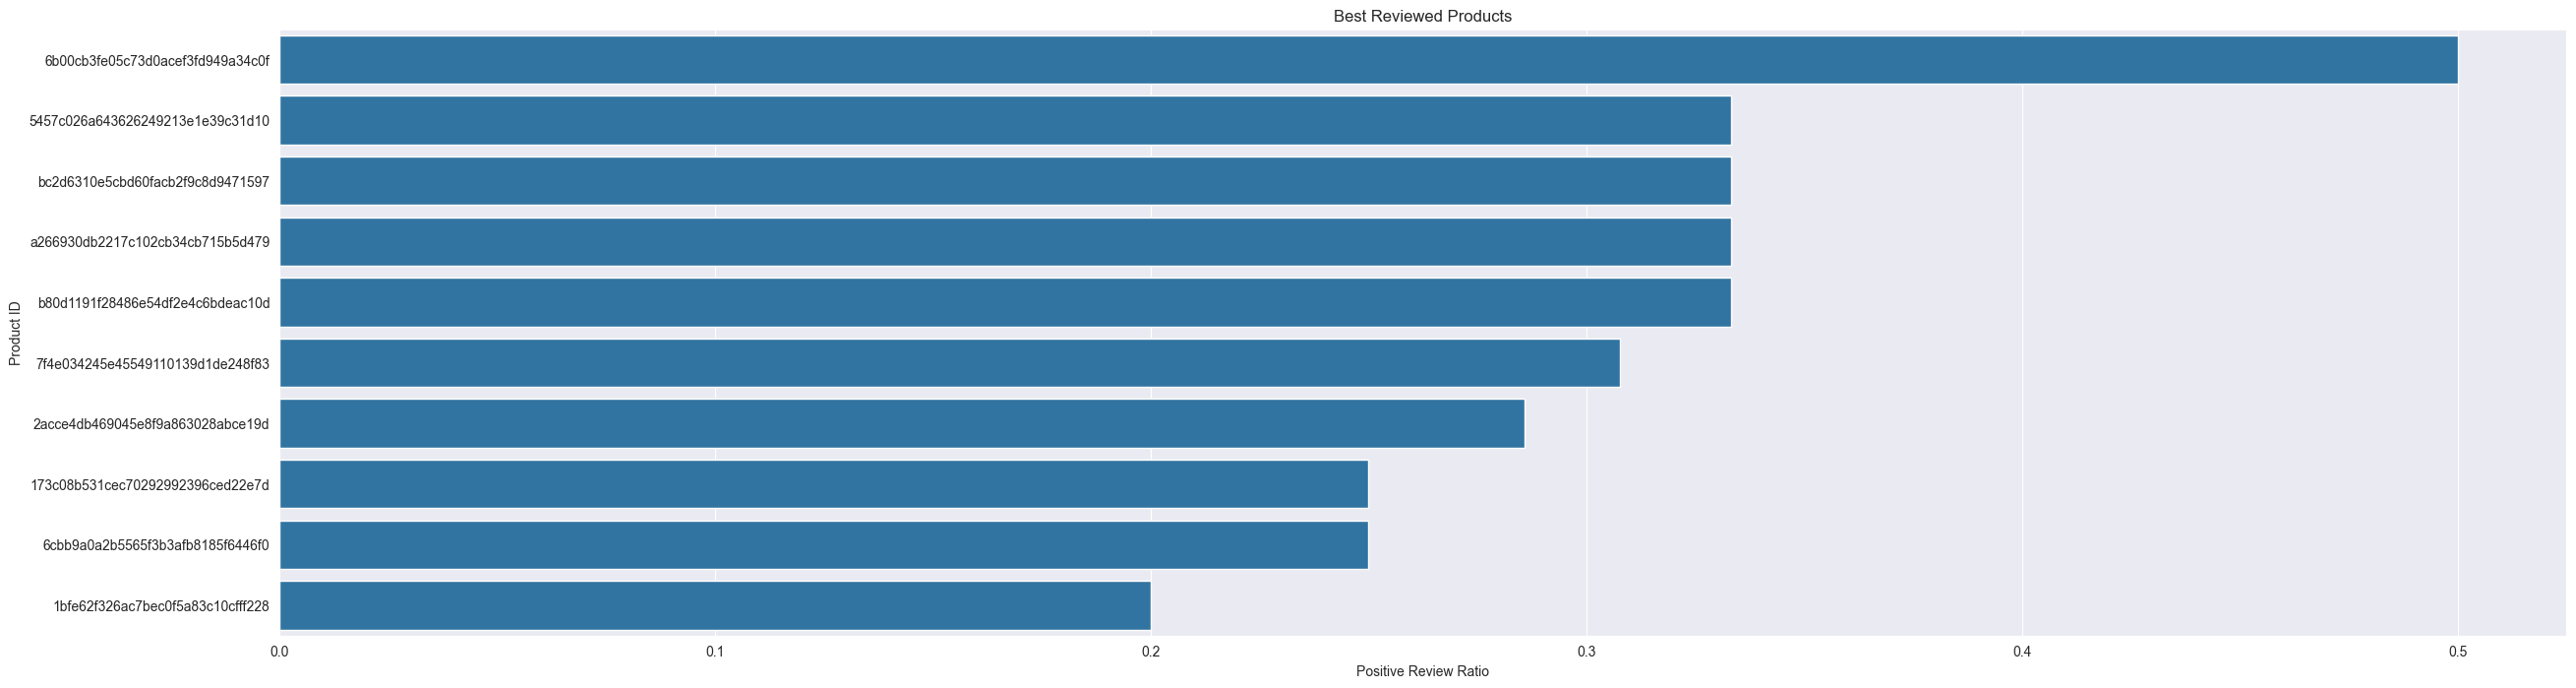

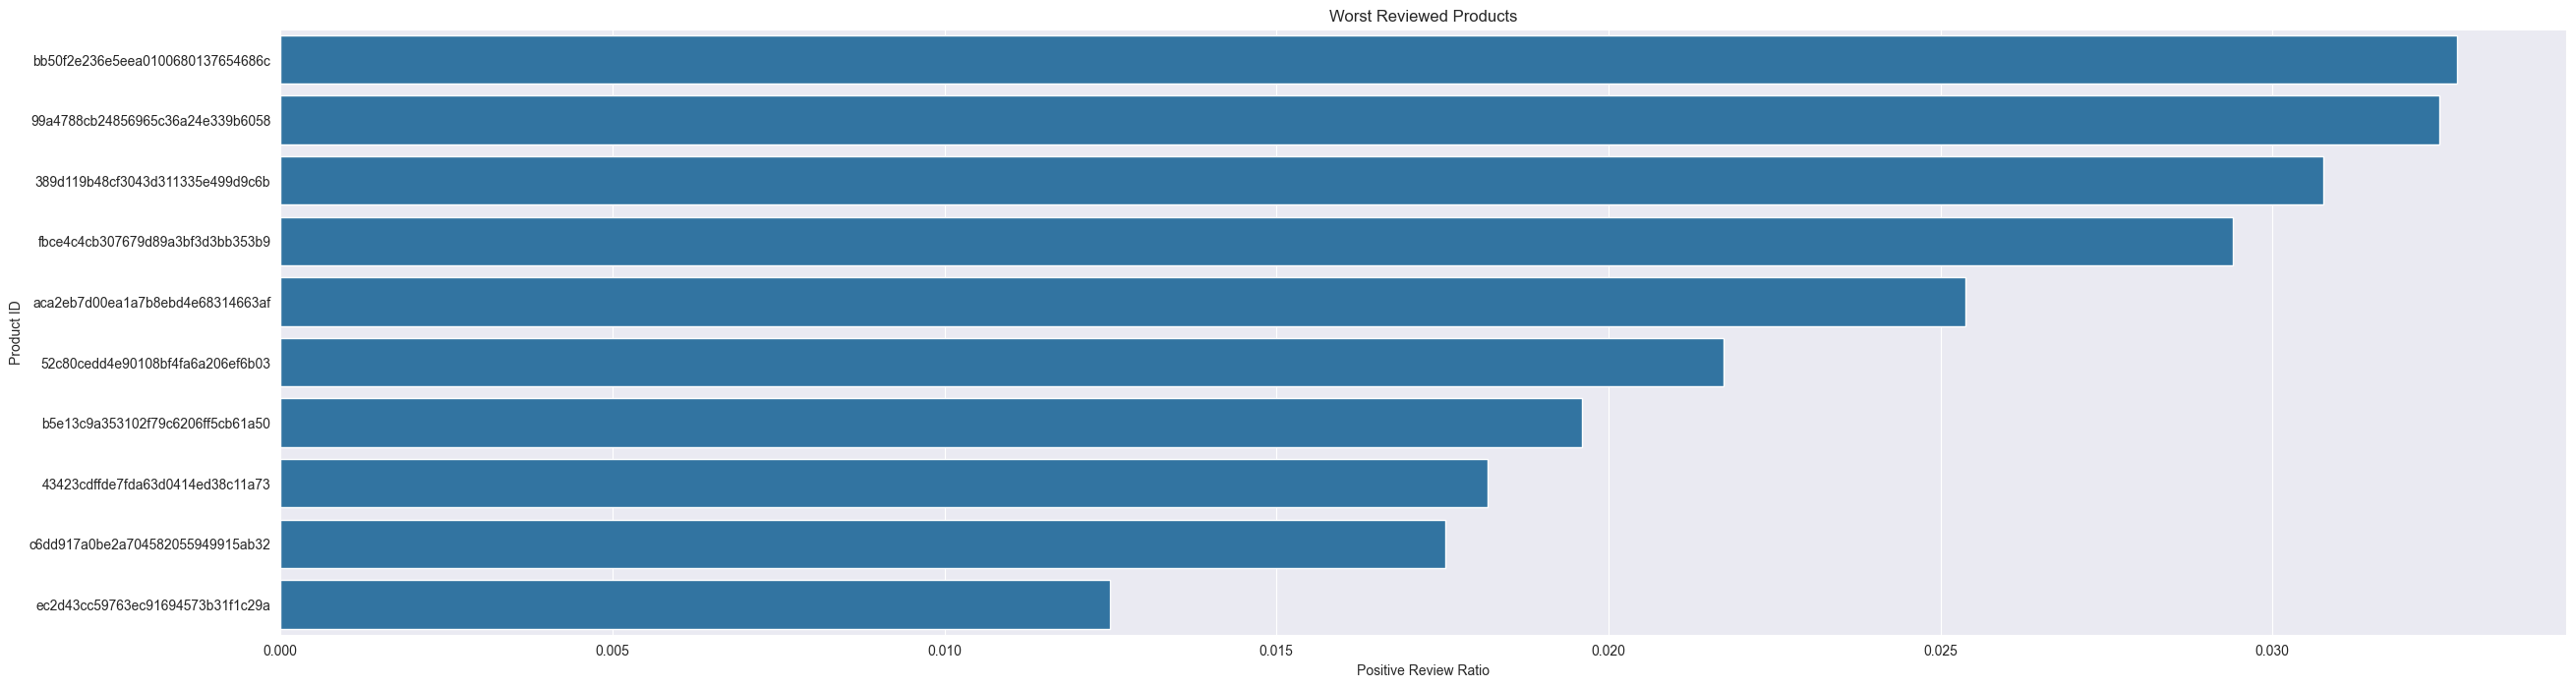

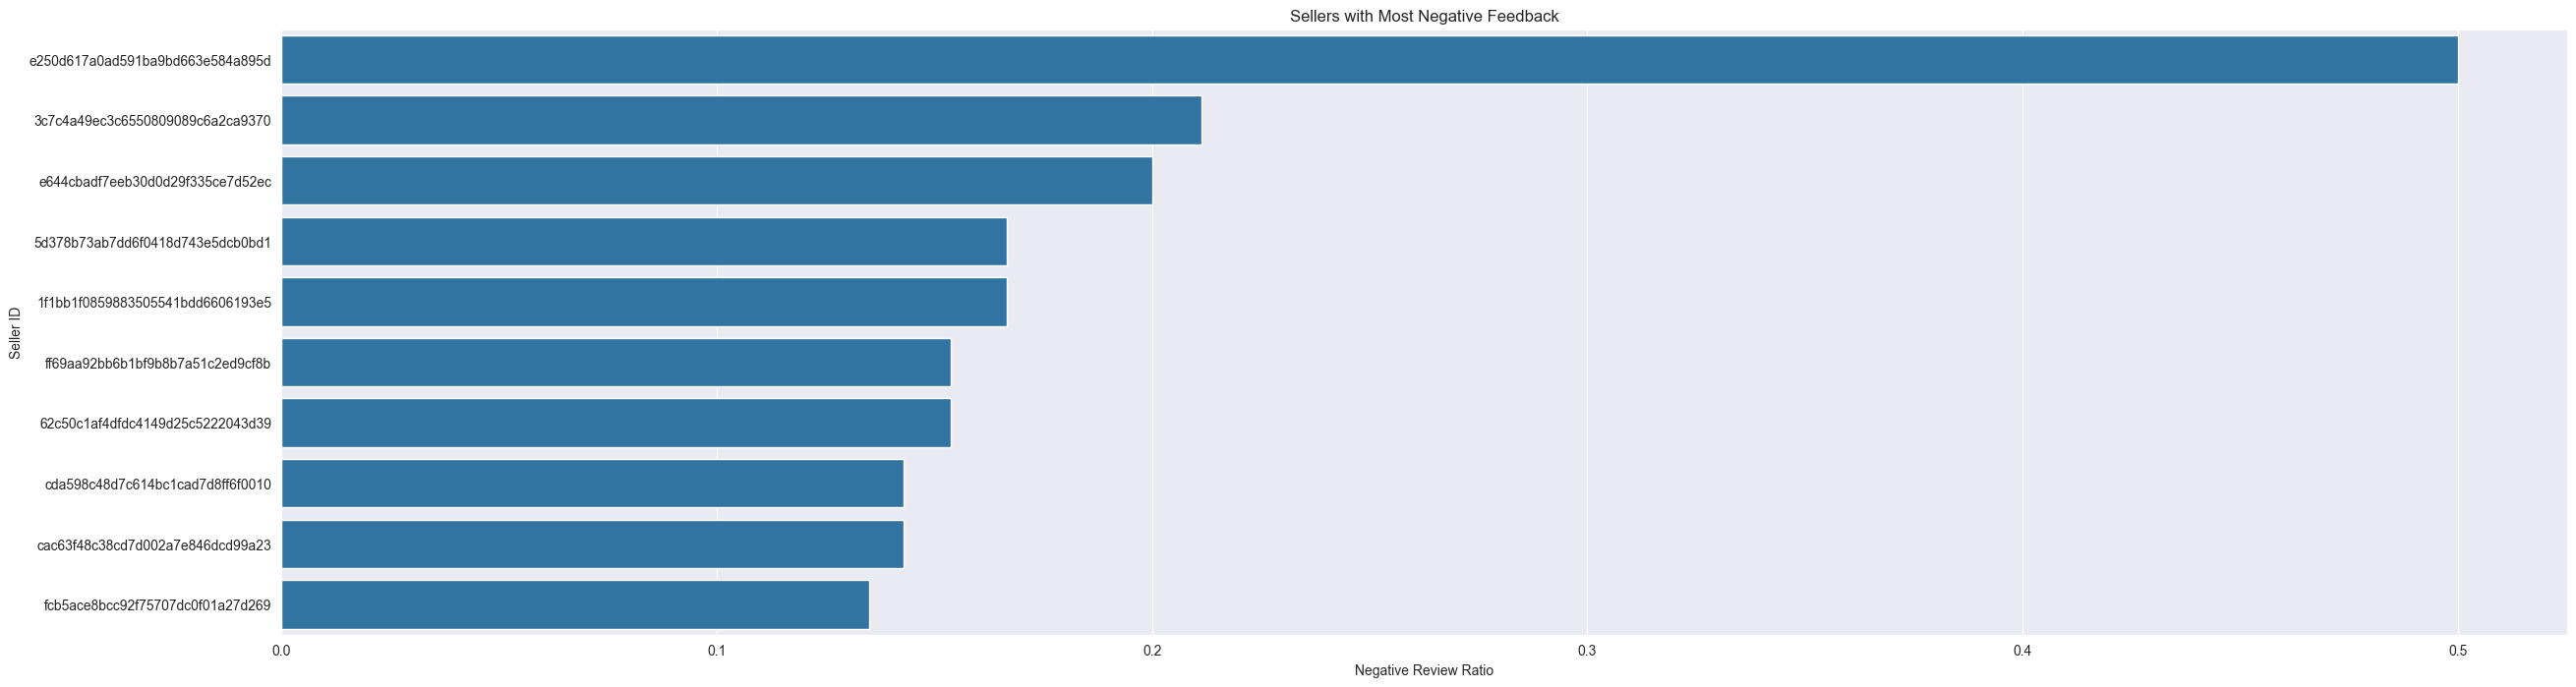

The comment is positive.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import re

# Load the datasets
products = pd.read_csv('D:/Smart/S_Data/products.csv')
order_reviews = pd.read_csv('D:/Smart/S_Data/order_reviews.csv')
orders = pd.read_csv('D:/Smart/S_Data/orders.csv')
sellers = pd.read_csv('D:/Smart/S_Data/sellers.csv')
order_items = pd.read_csv('D:/Smart/S_Data/order_items.csv')

# Remove rows with missing review comments
order_reviews = order_reviews.dropna(subset=['review_comment_message'])


# Preprocess text data
def clean_text(text):
    if isinstance(text, str):  # Ensure the input is a string
        text = text.lower()
        text = re.sub(r'\b\w{1,2}\b', '', text)  # Remove short words
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        return text
    return ""


order_reviews['clean_review_comment'] = order_reviews['review_comment_message'].apply(clean_text)


# Function to get sentiment
def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'


order_reviews['sentiment'] = order_reviews['clean_review_comment'].apply(get_sentiment)

# Add numerical ratings to the dataset
order_reviews = order_reviews.dropna(subset=['review_score'])

# Join with order_items to add product_id and seller_id to order_reviews
order_reviews = order_reviews.merge(order_items[['order_id', 'product_id', 'seller_id']], on='order_id', how='left')

# Best and worst reviewed products
product_sentiment = order_reviews.groupby(['product_id', 'sentiment']).size().unstack()

# Remove rows with missing values
product_sentiment = product_sentiment.dropna()

# Add total reviews and positive ratio
product_sentiment['total_reviews'] = product_sentiment.sum(axis=1)
product_sentiment['positive_ratio'] = product_sentiment['positive'] / product_sentiment['total_reviews']

# Filter out products with zero total reviews or missing values
product_sentiment = product_sentiment[product_sentiment['total_reviews'] > 0]

# Sort by positive ratio
product_sentiment = product_sentiment.sort_values(by='positive_ratio', ascending=False)

# Plot the distribution of review scores
plt.figure(figsize=(10, 6))
sns.histplot(order_reviews['review_score'], bins=5, kde=True)
plt.title('Distribution of Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.show()

# Correlation analysis
order_reviews['review_score'] = order_reviews['review_score'].astype(int)
sentiment_score = order_reviews.groupby('sentiment')['review_score'].mean().reset_index()

# Plot the average review score by sentiment
plt.figure(figsize=(10, 6))
sns.barplot(x='sentiment', y='review_score', data=sentiment_score)
plt.title('Average Review Score by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Review Score')
plt.show()

# Best and worst reviewed products
best_reviewed_products = product_sentiment.head(10)
worst_reviewed_products = product_sentiment.tail(10)

# Sellers with the most negative feedback
seller_reviews = order_reviews.merge(sellers[['seller_id', 'seller_city', 'seller_state']], on='seller_id', how='left')
seller_sentiment = seller_reviews.groupby(['seller_id', 'sentiment']).size().unstack()
seller_sentiment = seller_sentiment.dropna()
seller_sentiment['total_reviews'] = seller_sentiment.sum(axis=1)
seller_sentiment['negative_ratio'] = seller_sentiment['negative'] / seller_sentiment['total_reviews']
worst_sellers = seller_sentiment[seller_sentiment['total_reviews'] > 0].sort_values(by='negative_ratio',
                                                                                    ascending=False).head(10)


# Function to highlight price mentions
def highlight_price_mentions(text):
    return bool(re.search(r'\bprice\b', text))


order_reviews['mentions_price'] = order_reviews['clean_review_comment'].apply(highlight_price_mentions)
price_mentions = order_reviews[order_reviews['mentions_price']]

# Visualization of best and worst reviewed products
plt.figure(figsize=(30, 8))
sns.barplot(x='positive_ratio', y=best_reviewed_products.index, data=best_reviewed_products)
plt.title('Best Reviewed Products')
plt.xlabel('Positive Review Ratio')
plt.ylabel('Product ID')
plt.show()

plt.figure(figsize=(30, 8))
sns.barplot(x='positive_ratio', y=worst_reviewed_products.index, data=worst_reviewed_products)
plt.title('Worst Reviewed Products')
plt.xlabel('Positive Review Ratio')
plt.ylabel('Product ID')
plt.show()

# Visualization of sellers with the most negative feedback
plt.figure(figsize=(30, 8))
sns.barplot(x='negative_ratio', y=worst_sellers.index, data=worst_sellers)
plt.title('Sellers with Most Negative Feedback')
plt.xlabel('Negative Review Ratio')
plt.ylabel('Seller ID')
plt.show()


# Cell for classifying user text
def classify_comment(text):
    cleaned_text = clean_text(text)
    sentiment = get_sentiment(cleaned_text)
    return sentiment


# Testing the comment classification function
user_comment = input("Enter a comment for classification: ")
classification = classify_comment(user_comment)
print(f"The comment is {classification}.")
